#Import lib

In [6]:
!pip install cleverhans

In [7]:
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Conv2D, Input

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

import matplotlib.pyplot as plt


## LOAD CIFAR-10 DATASET

In [8]:
def ld_cifar10():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 127.5
        image -= 1.0
        return image, label

    dataset, info = tfds.load("cifar10", with_info=True, as_supervised=True)

    def augment_mirror(x):
        return tf.image.random_flip_left_right(x)

    def augment_shift(x, w=4):
        y = tf.pad(x, [[w] * 2, [w] * 2, [0] * 2], mode="REFLECT")
        return tf.image.random_crop(y, tf.shape(x))

    cifar10_train, cifar10_test = dataset["train"], dataset["test"]
    # Augmentation helps a lot in CIFAR10
    cifar10_train = cifar10_train.map(
        lambda x, y: (augment_mirror(augment_shift(x)), y)
    )
    cifar10_train = cifar10_train.map(convert_types).shuffle(10000).batch(128)
    cifar10_test = cifar10_test.map(convert_types).batch(1000)

    return EasyDict(train=cifar10_train, test=cifar10_test)

In [9]:
# Variables
nb_epochs=10


adv_train=False

# Load training and test data
data = ld_cifar10()
i = Input(shape = (32,32,3))
x = Conv2D(64, (3,3), padding="same", activation="relu")(i)
x = Conv2D(128, (3,3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.30)(x)
x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = Conv2D(128, (3,3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.30)(x)
x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = Conv2D(128, (3,3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(10)(x)

model = Model(i, x)
model.summary()

loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)

# Metrics to track the different accuracies.
train_loss = tf.metrics.Mean(name="train_loss")
train_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()
test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    predictions = model(x)
    loss = loss_object(y, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc_clean(y,predictions)

# Train model with adversarial training
for epoch in range(nb_epochs):
  # keras like display of progress
  progress_bar_train = tf.keras.utils.Progbar(50000)
  for (x, y) in data.train:
    if adv_train:
      # Replace clean example with adversarial example for adversarial training
      x = projected_gradient_descent(model, x, adv_perturbation_budget, 0.01, 40, np.inf)
    train_step(x, y)
    progress_bar_train.add(x.shape[0], values=[("epoch",epoch),("Loss (train)", train_loss.result())])



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 376,586 (1.44 MB)

 Trainable params: 376,330 (1.44 MB)

 Non-trainable params: 256 (1.00 KB)

50000/50000 ━━━━━━━━━━━━━━━━━━━━ 31s 622us/step - epoch: 0.0000e+00 - Loss (train): 1.8518
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 15s 297us/step - epoch: 1.0000 - Loss (train): 1.4719
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 15s 293us/step - epoch: 2.0000 - Loss (train): 1.2888
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 15s 295us/step - epoch: 3.0000 - Loss (train): 1.1668
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 16s 317us/step - epoch: 4.0000 - Loss (train): 1.0755
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 16s 310us/step - epoch: 5.0000 - Loss (train): 1.0058
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 15s 292us/step - epoch: 6.0000 - Loss (train): 0.9484
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 15s 295us/step - epoch: 7.0000 - Loss (train): 0.9016
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 14s 288us/step - epoch: 8.0000 - Loss (train): 0.8622
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 15s 292us/step - epoch: 9.0000 - Loss (train): 0.8281


 1000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/steptest acc on clean examples (%): 82.100
test acc on FGM adversarial examples (%): 12.700
test acc on PGD adversarial examples (%): 10.400
Maximum perturbation:  3.0


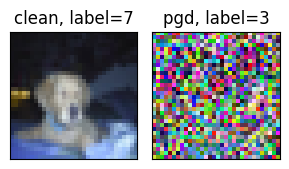

 2000/10000 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/steptest acc on clean examples (%): 82.200
test acc on FGM adversarial examples (%): 11.550
test acc on PGD adversarial examples (%): 10.350
Maximum perturbation:  2.7999995


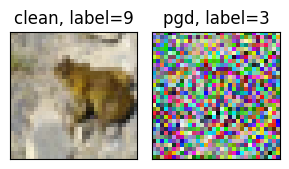

 3000/10000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/steptest acc on clean examples (%): 81.767
test acc on FGM adversarial examples (%): 11.967
test acc on PGD adversarial examples (%): 10.300
Maximum perturbation:  2.6000016


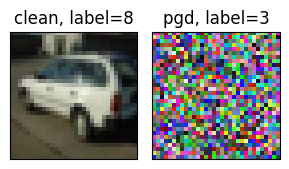

 4000/10000 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/steptest acc on clean examples (%): 80.775
test acc on FGM adversarial examples (%): 11.450
test acc on PGD adversarial examples (%): 10.325
Maximum perturbation:  3.0


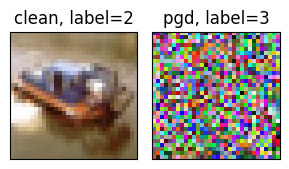

 5000/10000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/steptest acc on clean examples (%): 80.740
test acc on FGM adversarial examples (%): 11.360
test acc on PGD adversarial examples (%): 10.340
Maximum perturbation:  2.7999997


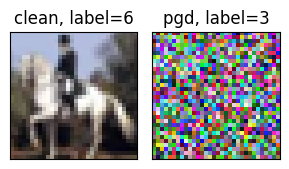

 6000/10000 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/steptest acc on clean examples (%): 81.033
test acc on FGM adversarial examples (%): 11.617
test acc on PGD adversarial examples (%): 10.233
Maximum perturbation:  2.6


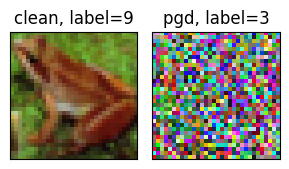

 7000/10000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/steptest acc on clean examples (%): 80.786
test acc on FGM adversarial examples (%): 11.743
test acc on PGD adversarial examples (%): 10.129
Maximum perturbation:  2.600002


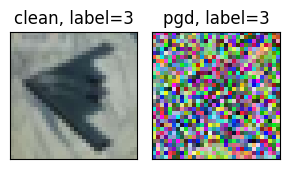

 8000/10000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step test acc on clean examples (%): 80.862
test acc on FGM adversarial examples (%): 11.700
test acc on PGD adversarial examples (%): 9.950
Maximum perturbation:  2.8000014


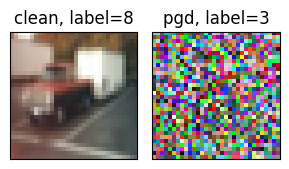

 9000/10000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/steptest acc on clean examples (%): 81.122
test acc on FGM adversarial examples (%): 11.689
test acc on PGD adversarial examples (%): 9.933
Maximum perturbation:  2.7999992


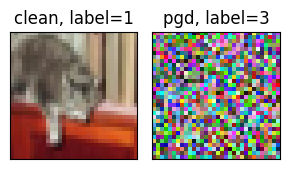

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
test acc on clean examples (%): 81.130
test acc on FGM adversarial examples (%): 11.710
test acc on PGD adversarial examples (%): 10.000
Maximum perturbation:  3.0


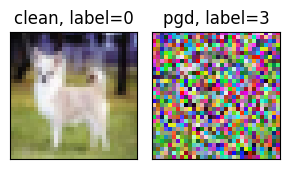

In [10]:
adv_perturbation_budget=3
pgd_iterations=40
pgd_step_budget=0.1


# Evaluate on clean and adversarial data
progress_bar_test = tf.keras.utils.Progbar(10000)


for x, y in data.test:
  #print(np.shape(x))
  y_pred = model(x)
  test_acc_clean(y, y_pred)

  #ATTACKS WITH FGSM
  x_fgm = fast_gradient_method(model, x, adv_perturbation_budget, np.inf)
  y_pred_fgm = model(x_fgm)
  test_acc_fgsm(y, y_pred_fgm)

  #ATTACKS WITH PGD (iterative attack)   ###################  (projected_gradient_descent)   C'est la ligne qui fait que l'on attaque    ###################
  #x_pgd = projected_gradient_descent(model, x, adv_perturbation_budget, pgd_step_budget, pgd_iterations, np.inf)


  target_labels =  tf.ones_like(y) * 3

  x_pgd = projected_gradient_descent(model, x,eps=3, eps_iter=0.1, nb_iter=40, norm=np.inf, y=target_labels, targeted=True)
  y_pred_pgd = model(x_pgd)
  test_acc_pgd(y, y_pred_pgd)

  #Print the clean accuracy (no attack) and the adversarial accuracy (i.e., the accuracy computed on the adversarial images)
  #NB: CIFAR-10 has 10 labels, the "random guess level" is accuracy=1/10=0.1
  progress_bar_test.add(x.shape[0])
  print("test acc on clean examples (%): {:.3f}".format(test_acc_clean.result() * 100))
  print("test acc on FGM adversarial examples (%): {:.3f}".format(test_acc_fgsm.result() * 100))
  print("test acc on PGD adversarial examples (%): {:.3f}".format(test_acc_pgd.result() * 100))

  #SHOW THE ATTACK
  rand_sample_id=np.random.randint(np.shape(x)[0])

  #We normalized our images into [0;1]. We make the inverse process to go into [0,255]
  #NB: For the attacked images, the max perturbation is +/-0.05, so the images will be in [-0.05,1.05]

  x_display = tf.cast(127.5*(x[rand_sample_id,:,:,:]+1.0),tf.uint8)
  x_pgd_display = tf.cast(121.4*(x_pgd[rand_sample_id,:,:,:]+1.05),tf.uint8)
  perturbation = x_pgd[rand_sample_id,:,:,:] - x[rand_sample_id,:,:,:]
  print('Maximum perturbation: ',np.amax(perturbation))



  #Normalize FGSM
  #x_display = tf.cast(127.5*(x[rand_sample_id,:,:,:]+1.0),tf.uint8)
  #x_fgm_display = tf.cast(121.4*(x_fgm[rand_sample_id,:,:,:]+1.05),tf.uint8)
  #perturbation = x_fgm[rand_sample_id,:,:,:] - x[rand_sample_id,:,:,:]
  #print('Maximum perturbation: ',np.amax(perturbation))

  #Display



  #PGD DISPLAY

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(3, 2), subplot_kw={'xticks': [], 'yticks': []})
  axs.flat[0].imshow(tf.cast(x_display,tf.uint8))
  axs.flat[0].set_title(str('clean, label=')+str(tf.get_static_value(y[0])))
  axs.flat[1].imshow(tf.cast(x_pgd_display,tf.uint8))
  axs.flat[1].set_title(str('pgd, label=')+str(np.argmax(tf.get_static_value(y_pred_pgd[0]))))
  plt.tight_layout()
  plt.show()





  #FGSM DISPLAY

  #fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(3, 2), subplot_kw={'xticks': [], 'yticks': []})
  #axs.flat[0].imshow(tf.cast(x_display,tf.uint8))
  #axs.flat[0].set_title(str('clean, label=')+str(tf.get_static_value(y[0])))
  #axs.flat[1].imshow(tf.cast(x_fgm_display,tf.uint8))
  #axs.flat[1].set_title(str('fgm, label=')+str(np.argmax(tf.get_static_value(y_pred_fgm[0]))))
  #plt.tight_layout()
  #plt.show()